# Basic FPM Simulation and Reconstruction Code

Neerja Aggarwal

Sep 11th, 2023

Start with a high resolution object and simulate measurements. Try a reconstruction. 

## Import and Setup

In [1]:
# load relevant libraries
# activate pytorch conda environment on fuoco

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import image
import math
import os
from IPython import display # for refreshing plotting

In [2]:
# set up to use the gpu
# ACTION: CHOOSE WHICH GPU TO USE (0-3)
use_gpu = True
#Can't see all GPUs?
gpu = 1  # 1 indexes to gpu2 titan xp
if use_gpu:
    os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
    torch.cuda.set_device(gpu)
    device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device('cpu') # uncomment this line to use cpu
torch.cuda.empty_cache()  #empty any variables in cache to free up space
print(device)

cuda:1


In [3]:
t = torch.cuda.get_device_properties(gpu).total_memory
print(t)
#print allocated memory
a = torch.cuda.memory_allocated(gpu)
c = torch.cuda.memory_reserved(gpu)
print(a)

12781879296
0


In [4]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Memory on GPU {i}: {torch.cuda.get_device_name(i)}")
        # print(f"  Allocated: {torch.cuda.memory_allocated(i) / 1024 ** 3:.2f} GB")
        # print(f"  Cached:    {torch.cuda.memory_reserved(i) / 1024 ** 3:.2f} GB")
        print(f"  Total:    {torch.cuda.get_device_properties(i).total_memory / 1024 ** 3:.2f} GB")

Memory on GPU 0: NVIDIA RTX A6000
  Total:    47.53 GB
Memory on GPU 1: NVIDIA TITAN Xp
  Total:    11.90 GB
Memory on GPU 2: NVIDIA GeForce RTX 3090
  Total:    23.69 GB


CHANGE experiment parameters here:

In [18]:
mag = 4 # 4x 
pix_size_camera = 4 #  micron
pix_size_object =pix_size_camera/mag # micron  
wv = 500e-3 # unit = micron,  wavelength is 500 nm
na_obj = 0.05 # low na objective 


# Create helper functions

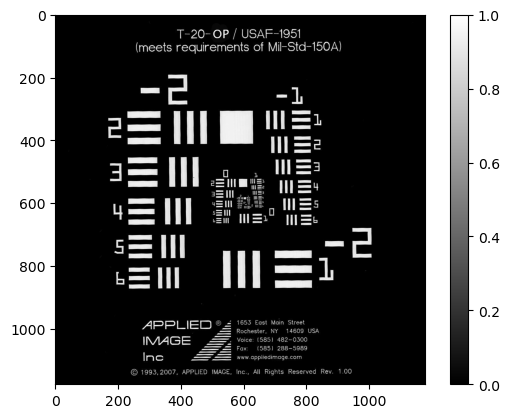

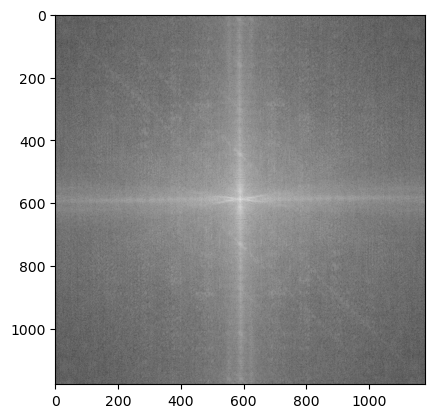

In [19]:
# start with an image in the object plane
# let's load a high resolution res target and just upsample for now?  we'll just do a mini version with limited angles. 
path = '/mnt/neerja-DATA/SpectralFPMData/usafrestarget.jpeg'
im = torch.from_numpy(image.imread(path))[:,:,0] # pick out the first channel

def preprocessObject(im):
    (Ny,Nx) = im.shape
    # make image square
    if Ny<Nx:
        im = im[:,1:Ny]
    elif Nx<Ny:
            im = im[1:Nx,:]
    # make even dimensions
    if Ny % 2 != 0:
        im = im[:-1,:]
    if Nx % 2 != 0:
        im = im[:,:-1]

    # normalize to max value is 1
    im = im/torch.amax(im)
    return im

im = preprocessObject(im)
(Ny,Nx) = im.shape
Npixel = Ny
# look at image
plt.imshow(im,'gray')
plt.colorbar()
pup_obj = torch.fft.fftshift(torch.fft.fft2(im))
plt.figure()
plt.imshow(torch.log10(torch.abs(pup_obj)),'gray')
# keep as amplitude only object (redundant info in frequency space)

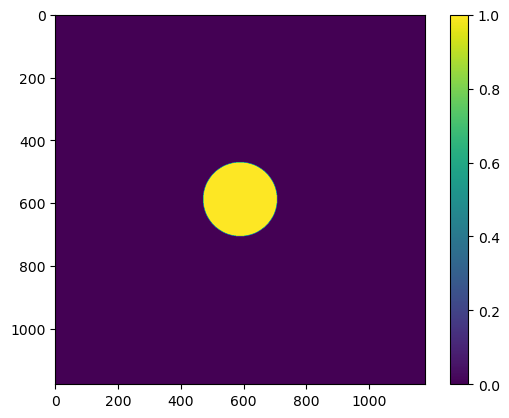

In [20]:
# make pupil mask
def createPupilStop(na_obj, wv, pix_size_object, Npixel):
    fPupilEdge = na_obj/wv # edge of pupipl is NA/wavelength
    fMax = 1/(2*pix_size_object)
    df = 1/(Npixel*pix_size_object)
    fvec = np.arange(-fMax,fMax,df)
    fxc,fyc = np.meshgrid(fvec,fvec)
    # caclulate radius of f coordinates
    frc = np.sqrt(fxc**2+fyc**2)
    pupil = np.zeros_like(frc) 
    pupil[frc<fPupilEdge] = 1 # make everything inside fPupilEdge transmit 100%
    return torch.Tensor(pupil)

pupil = createPupilStop(na_obj,wv,pix_size_object, Npixel)

plt.imshow(pupil)
plt.colorbar()


<Figure size 640x480 with 0 Axes>

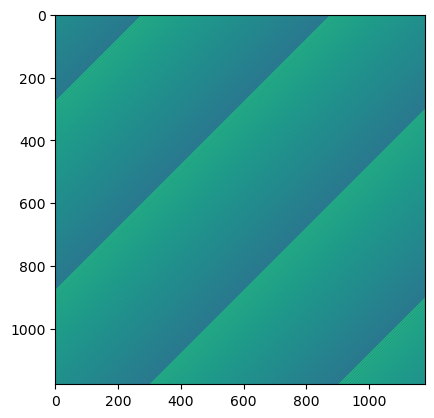

<Figure size 640x480 with 0 Axes>

In [21]:
# create xy grid for object space (used for illumination field)
def createXYgrid(pix_size_object,Nx,Ny):
    xvec = np.arange(-pix_size_object*Nx/2,pix_size_object*Nx/2,pix_size_object)
    yvec = np.arange(-pix_size_object*Ny/2,pix_size_object*Ny/2,pix_size_object)
    xygrid = torch.Tensor(np.meshgrid(xvec,yvec))
    return xygrid

# create the illumination field given angle of planewave
def createIllumField(xygrid, illum_angle, wv):
    rady = illum_angle[0]
    radx = illum_angle[1]
    k0 = 2*math.pi/wv
    ky = k0*math.sin(rady)
    kx = k0*math.sin(radx)
    field = torch.exp(1j*kx*xygrid[1] + 1j*ky*xygrid[0])
    return field

# look at an example illumination field
illum_angle = (.1,.1)  # y,x  # unit is in radians
xygrid = createXYgrid(pix_size_object,Nx,Ny)
field = createIllumField(xygrid,illum_angle,wv)
plt.imshow(torch.angle(field))
plt.figure()

Text(0.5, 1.0, 'Object')

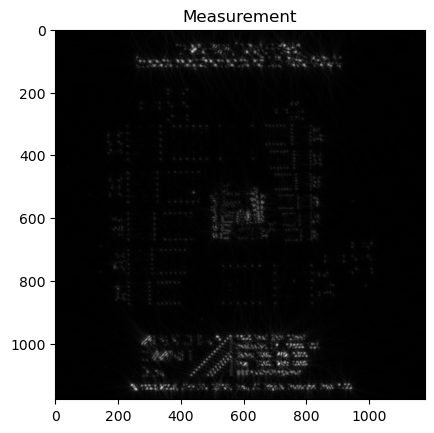

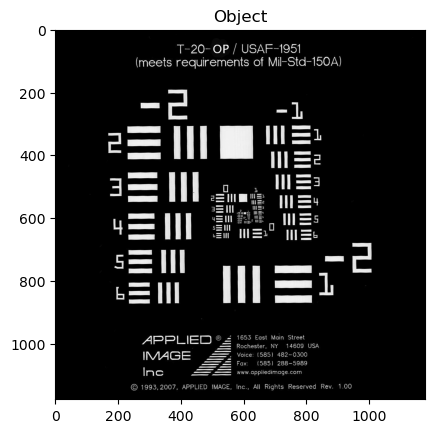

In [22]:
# compute the measurement given an object and incident wave field and pupil stop
def forwardFPM(obj, pupil, field):
    # multiply by the sample
    obj_field = field*obj
    # take the fourier transform and center in pupil plane
    pup_obj = torch.fft.fftshift(torch.fft.fft2(obj_field))*pupil
    # multiply object's FFT with the pupil stop and take ifft to get measurement
    y = torch.abs(torch.fft.ifft2(torch.fft.fftshift(pup_obj)))
    # subsample according to pixel size on camera?
    return (y, pup_obj)

# look at an example measurement
(y, pup_obj) = forwardFPM(im,pupil, field)
plt.imshow(torch.abs(y),'gray')
plt.title('Measurement')
plt.figure()
plt.imshow(im,'gray')
plt.title('Object')

## Simulate lots of forward measurements


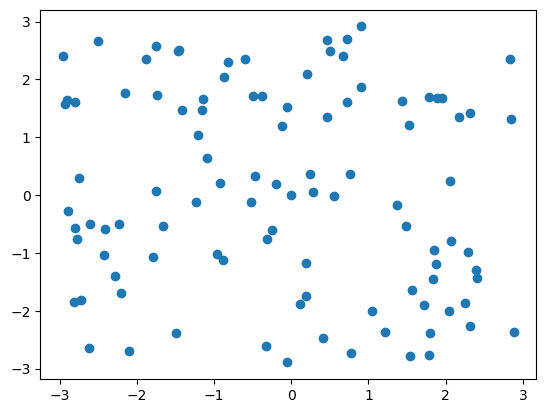

In [23]:
# create list of illumination angles (leds) to turn on one at a time
def createlist_led(num_leds,minval,maxval):
    list_leds = np.random.uniform(low = minval, high = maxval, size = (num_leds,2))
    # append a (0,0) bf led
    list_leds = np.append(list_leds,np.zeros([1,2]), axis = 0 )
    return list_leds
list_leds = createlist_led(100,-3,3) 
plt.scatter(list_leds[:,1],list_leds[:,0])

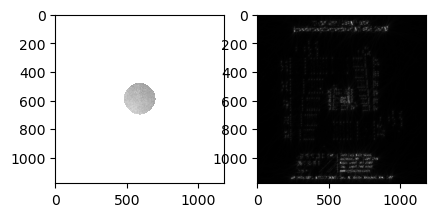

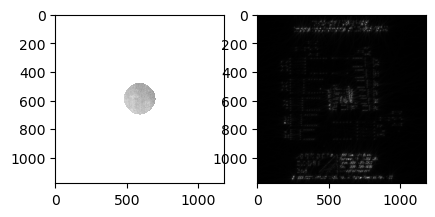

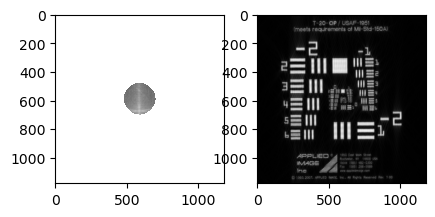

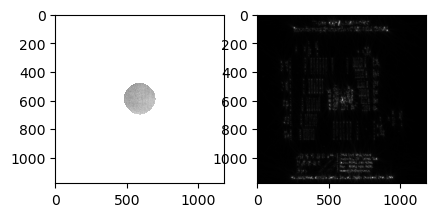

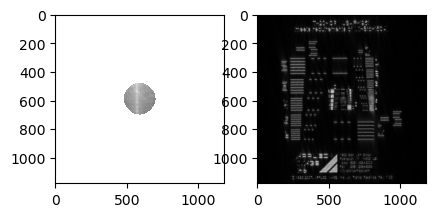

In [24]:
d = 75 # distance away led to object
# let's go up to 15 mm out (15/5 = 3)
led_spacing = 5 # roughly 5 mm apart LEDs
num_meas = len(list_leds) 
# load data
obj = torch.from_numpy(image.imread(path))[:,:,0] # pick out the first channel
obj = preprocessObject(obj) # make it square and even
(Ny,Nx) = obj.shape
Npixel = Ny

# create grid and pupil
xygrid = createXYgrid(pix_size_object,Nx,Ny)
pupil = createPupilStop(na_obj,wv,pix_size_object, Npixel)
measstack = torch.zeros(num_meas,Ny,Nx)

for k in np.arange(num_meas):
    # take led indices and calculate angle of incidence
    led_ind = list_leds[k]  
    led_pos = (led_ind[0]*led_spacing,led_ind[1]*led_spacing,d) # units = millimeters, (x,y,z)
    illum_angle = (np.arctan(led_pos[0]/led_pos[2]), np.arctan(led_pos[1]/led_pos[2]))

    # create illumination field and simulate the forward measurement
    field = createIllumField(xygrid,illum_angle,wv)
    (y,pup_obj) = forwardFPM(obj,pupil, field)

    # plot some example measurements
    if k<5:
        plt.figure(figsize=(10,10))
        plt.subplot(1,4,1)
        plt.imshow(torch.log10(torch.abs(pup_obj)),'gray')
        plt.subplot(1,4,2)
        plt.imshow(torch.abs(y),'gray')
    measstack[k,:,:] = y




## Reconstruction

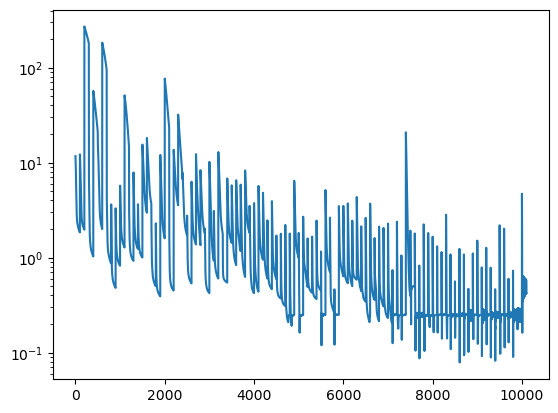

In [25]:
# obj_est = torch.zeros_like(obj,dtype = torch.float) # initializing to zeros doesn't work well. 
obj_est = measstack[0,:,:] # initialize to first measurement instead
obj_est = obj_est/torch.amax(obj_est)
obj_est.requires_grad = True

# regularizers
def hardthresh(x,val):
    return torch.maximum(x,torch.tensor(val))

# move variables to gpu while keeping autograd functional on them
if use_gpu == True:
    with torch.no_grad(): # Tip: need to do inplace operations inside this no_grad() function to retain as leaf variables 
        obj_est = obj_est.to(device)
        obj_est.requires_grad = True
        pupil = pupil.to(device)

# set hyperparameters
step_size = 1e0
num_iters = 100
num_meas = len(list_leds)
losses = []


# start reconstruction loop. 
for k2 in np.arange(num_meas): # iterate one measurement at a time
    for k1 in np.arange(num_iters):
        # print iteration index
        # print(k2,k1)

        # get relevant actual measurement and move to gpu
        meas = measstack[k2,:,:].to(device) 

        # compute illumination angle from led indices
        led_ind = list_leds[k2]   #
        led_pos = (led_ind[0]*led_spacing,led_ind[1]*led_spacing,d) # units = millimeters, (x,y,z)
        illum_angle = (np.arctan(led_pos[0]/led_pos[2]), np.arctan(led_pos[1]/led_pos[2]))

        # create illumination field and simulate forward measurement
        field = createIllumField(xygrid,illum_angle,wv).to(device)
        (yest,pup_obj) = forwardFPM(obj_est,pupil, field)

        # calculate error, aka loss, and backpropagate
        error = torch.norm(yest-meas)
        losses += [error.detach().cpu()]
            # print(error)
        error.backward()
        # print(error)

        # update the object's reconstruction estimate based on error
        with torch.no_grad(): # need to do inplace operations inside this no_grad() function to retain as leaf variables. 
            # print(torch.norm(obj_est.grad))
            obj_est = obj_est - step_size*obj_est.grad # gradient update
            obj_est = hardthresh(obj_est,0) # proximal update

        # ensure the obj_est's grad flag is set correctly for next iteration to run properly
        obj_est.requires_grad = True

        if k1 == num_iters-1:
                try:
                    print(k2,k1)
                    plt.clf() # clear plot
                    plt.semilogy(losses)
                    display.display(plt.gcf()) # update single window
                    display.clear_output(wait=True) # update single window
                    # time.sleep(1)
                except KeyboardInterrupt:
                    break



tensor(266.2982, device='cuda:1', grad_fn=<LinalgVectorNormBackward0>)


Text(0.5, 1.0, 'Brightfield Image')

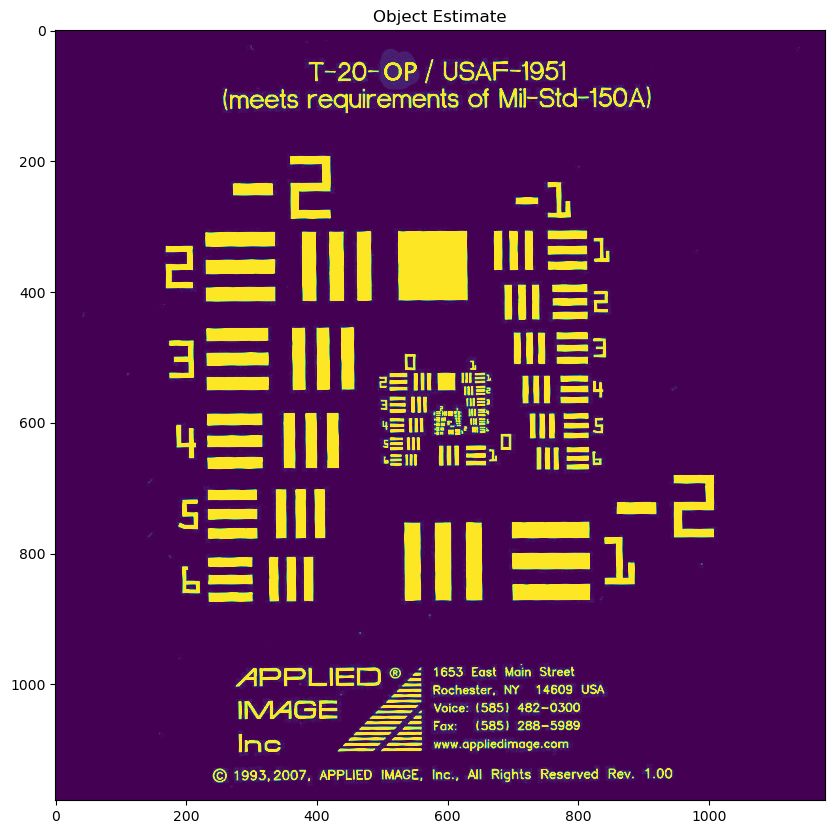

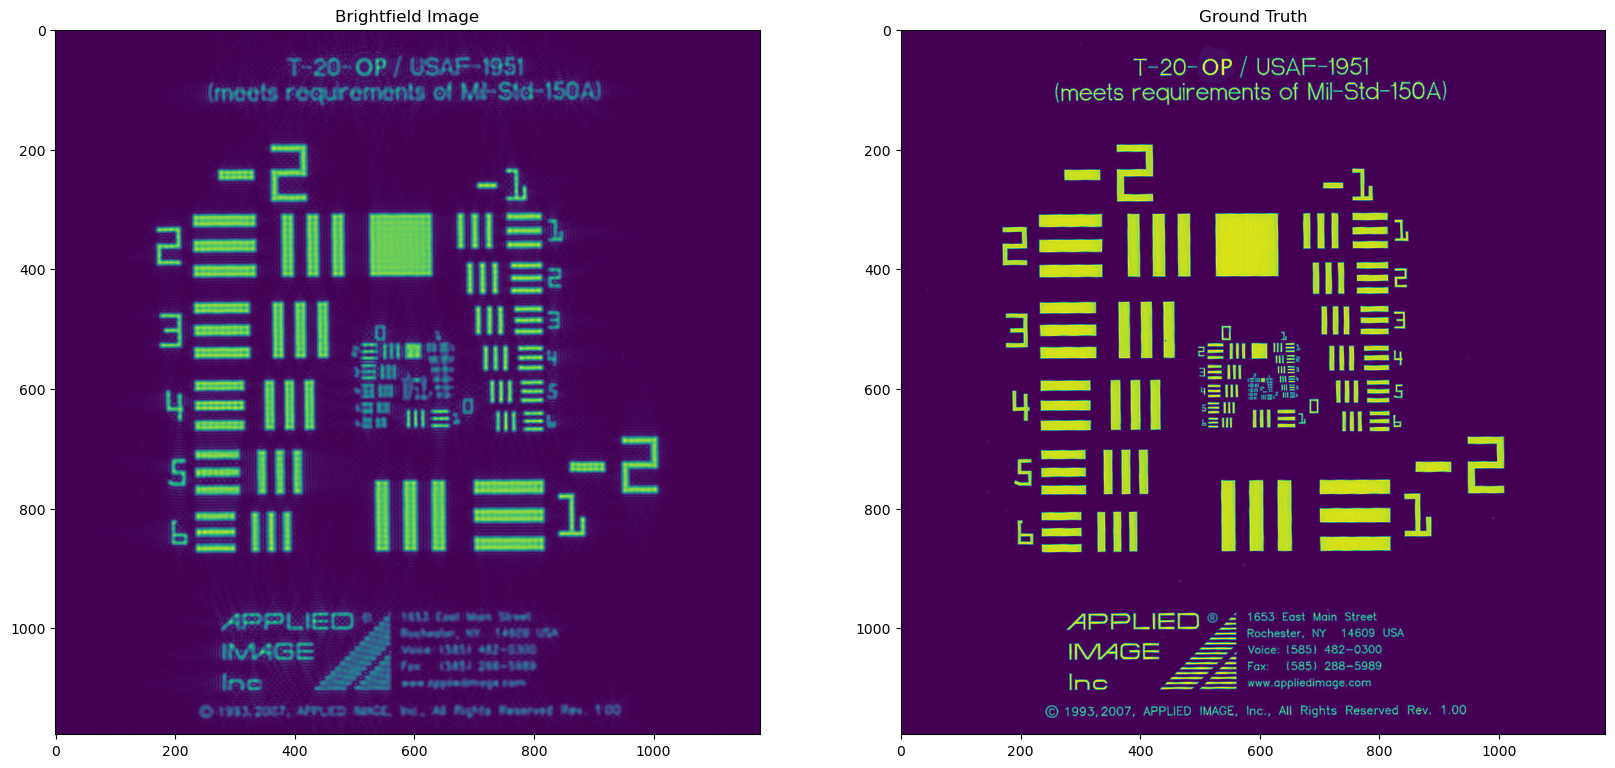

In [26]:
plt.figure(figsize = (10,10))
obj_est_norm = hardthresh(obj_est,0)
obj_est_norm = obj_est_norm/torch.amax(obj_est_norm)
plt.imshow(obj_est_norm.detach().cpu().numpy())
plt.title('Object Estimate')
print(torch.norm(obj_est_norm))
# plt.colorbar()
plt.clim([0,.3])

plt.figure(figsize = (20,20))
plt.subplot(1,2,2)
plt.imshow(obj)
# plt.colorbar()
plt.title('Ground Truth')

plt.subplot(1,2,1)
plt.imshow(measstack[-1,:,:])
plt.title('Brightfield Image')
# plt.colorbar()
# plt.clim([0,.3])

Text(0.5, 1.0, 'Meas0 FFT')

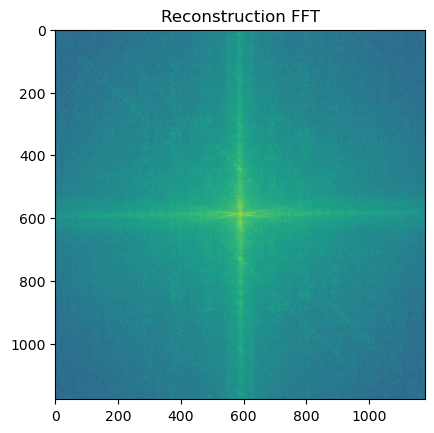

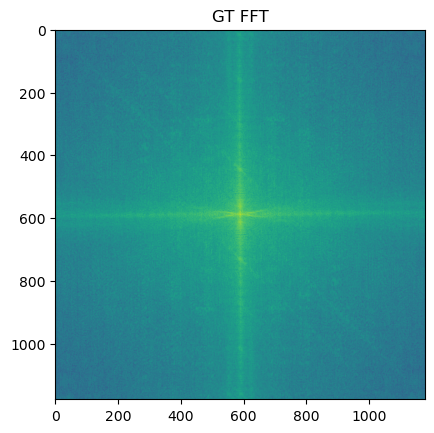

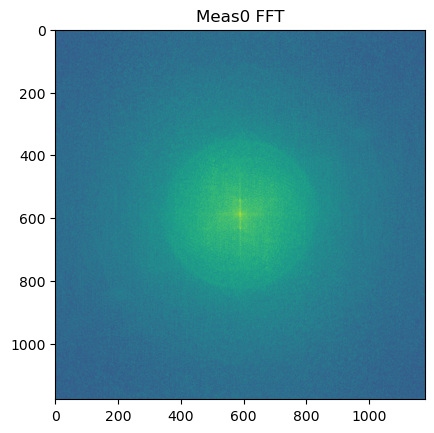

In [27]:
# compute the object reconstruction's fourier transform and plot
f = torch.fft.fftshift(torch.fft.fft2(obj_est)).detach().cpu()
plt.imshow(torch.log10(torch.abs(f)))
plt.title('Reconstruction FFT')

plt.figure()
f = torch.fft.fftshift(torch.fft.fft2(obj)).detach().cpu()
plt.imshow(torch.log10(torch.abs(f)))
plt.title('GT FFT')


plt.figure()
# compute the object reconstruction's fourier transform and plot
f = torch.fft.fftshift(torch.fft.fft2(measstack[0,:,:])).detach().cpu()
plt.imshow(torch.log10(torch.abs(f)))
plt.title('Meas0 FFT')

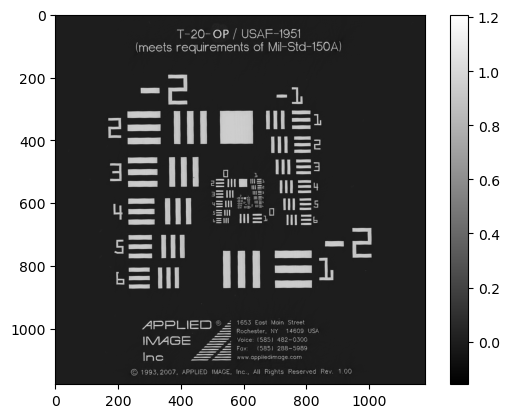

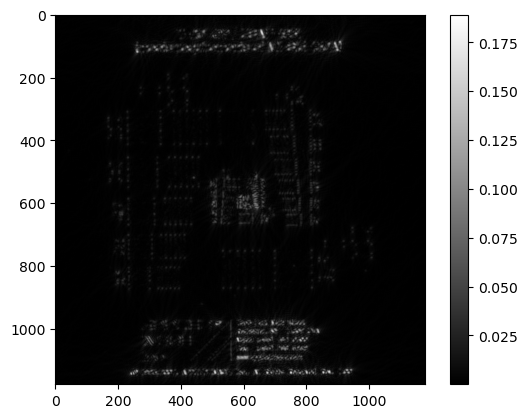

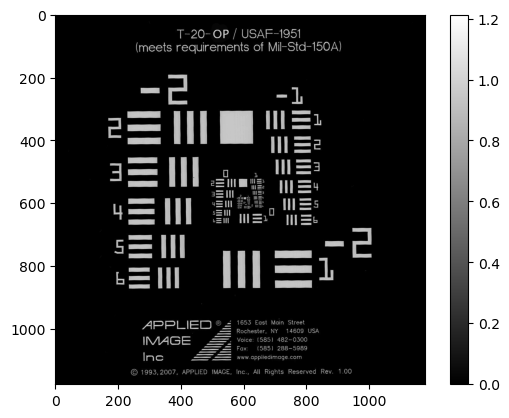

In [28]:
descent = obj_est.detach().cpu().numpy() - measstack[0,:,:].detach().cpu().numpy()
plt.imshow(descent,'gray')
plt.colorbar()

plt.figure()
plt.imshow(measstack[0,:,:],'gray')
plt.colorbar()

plt.figure()
plt.imshow(obj_est.detach().cpu().numpy(),'gray')
plt.colorbar()
